# Task 2: Data Preparation and Analysis

In this part of the assignment, I will collect detailed data for the Top 20 goalscorers in 10 competitions(9 different leagues and the World Cup 2018).

The JSON data collected from Task 1 will be used to analyse this data. 

In [318]:
import json
from pathlib import Path
from datetime import datetime
from datetime import date
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline
import statistics as stat

Setting the colours for the various competetions and other key setting for displays and plotting to be used.

In [319]:
#competions that are going to be studied
competition_names = ["Premier League", "La Liga", "Seria A", "Ligue 1", "Campeonato Brasileiro Série A", "Primera Liga", "Bundesliga", "Eredevisie", "English Championship", "World Cup"]
#dictionary for the competition and the competition codes
competition_dict = {"Premier League":"PL", "La Liga":"PD", "Seria A":"SA", "Ligue 1":"FL1", "Campeonato Brasileiro Série A":"BSA", "Primera Liga":"PPL", "Bundesliga": "BL1", "Eredevisie": "DED", "English Championship":"ELC", "World Cup": "WC"}
#file names for the files saved in Task1
file_names = ["PL", "PD", "SA", "FL1", "BSA", "PPL", "BL1", "DED", "ELC", "WC"]
# Precision that we'll use for Pandas display
pd.set_option('precision', 2)
#set default font size
fontsize = 16
#dictionary containing the competition winners(to be used as a column in data frame)
dict_winners={"Premier League":"Manchester City FC", "La Liga":"Club Atlético de Madrid", "Seria A":"FC Internazionale Milano", "Ligue 1":"PSG", "Campeonato Brasileiro Série A":"CR Flamengo", "Primera Liga":"Sporting Clube de Portugal", "Bundesliga":"FC Bayern München", "Eredevisie":"AFC Ajax", "English Championship":"Norwich City FC", "World Cup":"France"}
#dictionary containing the number of mathcdays in every competition
dict_matchdays={"Premier League":38, "La Liga":38, "Seria A":38, "Ligue 1":38, "Campeonato Brasileiro Série A":38, "Primera Liga":34, "Bundesliga":34, "Eredevisie":34, "English Championship":46, "World Cup":7}

Setting directories to store the data.

In [320]:
# directory for raw data storage
dir_raw = Path("rawdata")
# directory for storing clean pre-processed data
dir_data = Path("cleaneddata")
# make sure it exists
dir_data.mkdir(parents=True, exist_ok=True)

# Data Parsing
Function to parse an individual JSON data file from the Football Data API.

Data will be parsed based on characteristics of the top goalscorers such as their name, position, name, nationality, goals scored, age etc..

In [321]:
def parse_raw_data(competition_name,file_name, fpath):
    file_path  ="%s/%s.json"%(Path("rawdata"), fpath)
    fin = open(file_path, "r")
    jdata = fin.read()
    data = json.loads(jdata)
    # handle each observation
    rows = []
    count=1
    #for each top scorer in data set set rows for observations
    for ts in data["scorers"]:
        row = {"Competition": competition_name}
        row["Rank"]=count
        count+=1
        #add the names of the players on the top scorers list
        row["Name"] = ts["player"]["name"]
        #add the goals number of goals scored by players
        row["Goals"] = ts["numberOfGoals"]
        #add the position that the players play in 
        row["Position"] = ts["player"]["position"]
        #add the nationality of players
        row["Nationality"] = ts["player"]["nationality"]
        #add player age given by their date of birth 
        row["Age"] = ts["player"]["dateOfBirth"]
        #add the team that each player plays for 
        row["Team"] = ts["team"]["name"]
        #add matchday gives the total number of games played in the season
        row["Matchdays"] = dict_matchdays[competition_name]
        #add the name of the team that won the competition(i.e the league that year or the 2018 World Cup)
        row["Comp Winner"] = dict_winners[competition_name]
        rows.append(row)
    count=1
    fin.close()
    # return back the DataFrame
    return pd.DataFrame(rows).set_index("Competition")

In [322]:
#parsing the dataset
df_topscorers = {}
for competition in competition_names:
    print("Parsing data for %s"%competition_dict[competition])
    league = parse_raw_data(competition,dir_raw,competition_dict[competition])
    df_topscorers[competition] = league

Parsing data for PL
Parsing data for PD
Parsing data for SA
Parsing data for FL1
Parsing data for BSA
Parsing data for PPL
Parsing data for BL1
Parsing data for DED
Parsing data for ELC
Parsing data for WC


# Data Verification
Check format for Top Scorers data frame is correct:

In [323]:
df_topscorers["Premier League"].head()

,Rank,Name,Goals,Position,Nationality,Age,Team,Matchdays,Comp Winner
Competition,,,,,,,,,
Premier League,1,Harry Kane,23,Attacker,England,1993-07-28,Tottenham Hotspur FC,38,Manchester City FC
Premier League,2,Mohamed Salah,22,Attacker,Egypt,1992-06-15,Liverpool FC,38,Manchester City FC
Premier League,3,Bruno Fernandes,18,Midfielder,Portugal,1994-09-08,Manchester United FC,38,Manchester City FC
Premier League,4,Patrick Bamford,17,Attacker,England,1993-09-05,Leeds United FC,38,Manchester City FC
Premier League,5,Son Heungmin,17,Midfielder,Korea Republic,1992-07-08,Tottenham Hotspur FC,38,Manchester City FC


In [324]:
df_topscorers["World Cup"].head()

,Rank,Name,Goals,Position,Nationality,Age,Team,Matchdays,Comp Winner
Competition,,,,,,,,,
World Cup,1,Harry Kane,6,Attacker,England,1993-07-28,England,7,France
World Cup,2,Denis Cheryshev,4,Attacker,Russia,1990-12-26,Russia,7,France
World Cup,3,Cristiano Ronaldo,4,Attacker,Portugal,1985-02-05,Portugal,7,France
World Cup,4,Antoine Griezmann,4,Attacker,France,1991-03-21,France,7,France
World Cup,5,Romelu Lukaku,4,Attacker,Belgium,1993-05-13,Belgium,7,France


# Data Analysis

# Top Scorer Analysis

Firstly, we will analysis the raw statistics of the top 20 scorers from the 10 different competitions.

In [325]:
#Function that computes the raw statitics(mean,min,max,standard deviation)
def compute_stats(col_name):
    rows = []
    for competition in competition_names:
        row = {"Competition": competition}
        row["Matchdays"] = dict_matchdays[competition]
        row["Max"] = df_topscorers[competition][col_name].max()
        row["Min"] = df_topscorers[competition][col_name].min()
        row["Mean"] = df_topscorers[competition][col_name].mean()
        row["Median"] = df_topscorers[competition][col_name].median()
        row["Standard Dev."] = stat.stdev(df_topscorers[competition][col_name])
        rows.append(row)
    return pd.DataFrame(rows).set_index("Competition")

In [326]:
topscorer_stats = compute_stats("Goals")
topscorer_stats

,Matchdays,Max,Min,Mean,Median,Standard Dev.
Competition,,,,,,
Premier League,38,23,10,14.05,12.5,3.72
La Liga,38,30,9,14.80,12.5,5.44
Seria A,38,29,11,16.55,15.5,4.97
Ligue 1,38,27,10,14.55,14.0,4.24
Campeonato Brasileiro Série A,38,18,9,12.35,11.0,3.08
Primera Liga,34,24,7,11.45,9.0,5.00
Bundesliga,34,41,8,14.40,11.0,8.77
Eredevisie,34,26,10,14.00,13.5,3.88
English Championship,46,30,9,15.45,13.5,6.16


We can see that the league that had the highest scorer was the Bundesliga where the Top Scorer had 41 goals.

In [327]:
def compute_maxandmin(col_name):
    rows = []
    for competition in competition_names:
        row = {"Competition": competition}
        row["Max"] = df_topscorers[competition][col_name].max()
        row["Min"] = df_topscorers[competition][col_name].min()
        rows.append(row)
    return pd.DataFrame(rows).set_index("Competition")

In [328]:
max_min_stats = compute_maxandmin("Goals")
max_min_stats

,Max,Min
Competition,,
Premier League,23,10
La Liga,30,9
Seria A,29,11
Ligue 1,27,10
Campeonato Brasileiro Série A,18,9
Primera Liga,24,7
Bundesliga,41,8
Eredevisie,26,10
English Championship,30,9


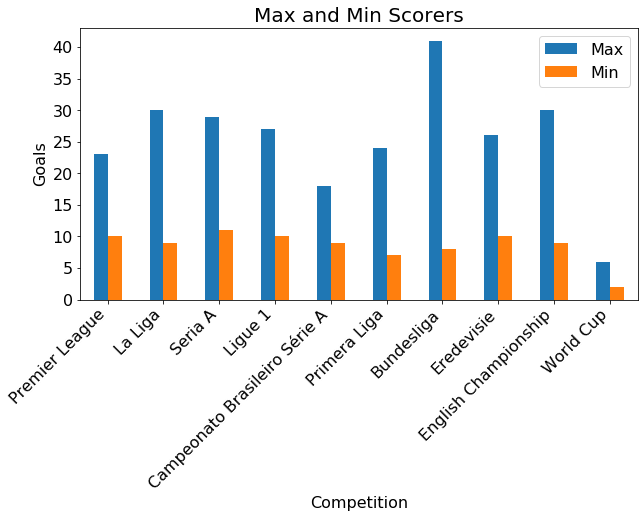

In [329]:
#graphical display of max and min scorers
df = max_min_stats.plot.bar(figsize=(10,5),fontsize=fontsize)
df.legend(fontsize=fontsize)
df.set_title("Max and Min Scorers", fontsize = 20)
df.set_xlabel("Competition", fontsize = fontsize)
df.set_ylabel("Goals", fontsize=fontsize)
plt.xticks(rotation=45, ha='right');

In [330]:
def compute_meanandstd(col_name):
    rows = []
    for competition in competition_names:
        row = {"Competition": competition}
        row["Mean"] = df_topscorers[competition][col_name].mean()
        row["Standard Dev."] = stat.stdev(df_topscorers[competition][col_name])
        rows.append(row)
    return pd.DataFrame(rows).set_index("Competition")

In [331]:
mean_std_stats = compute_meanandstd("Goals")
mean_std_stats

,Mean,Standard Dev.
Competition,,
Premier League,14.05,3.72
La Liga,14.80,5.44
Seria A,16.55,4.97
Ligue 1,14.55,4.24
Campeonato Brasileiro Série A,12.35,3.08
Primera Liga,11.45,5.00
Bundesliga,14.40,8.77
Eredevisie,14.00,3.88
English Championship,15.45,6.16


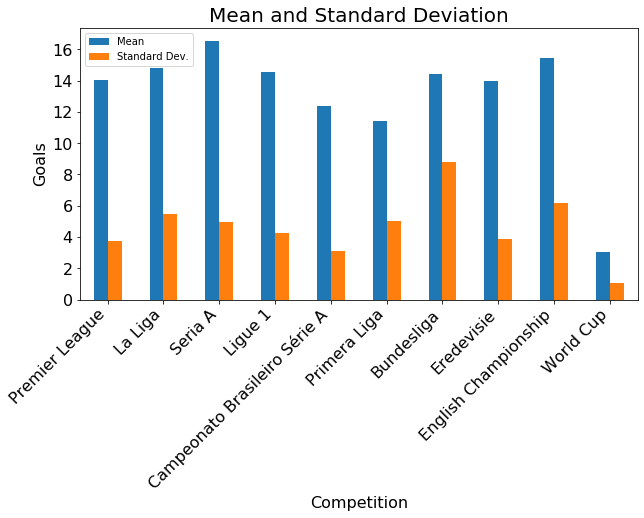

In [332]:
#graphical display of mean and std
graph = mean_std_stats.plot.bar(figsize=(10,5),fontsize=fontsize)
graph.set_title("Mean and Standard Deviation", fontsize = 20)
graph.set_xlabel("Competition", fontsize = fontsize)
graph.set_ylabel("Goals", fontsize=fontsize)
plt.xticks(rotation=45, ha='right');

We can now analyse these raw statistics based on the number of matchdays in the competition.

Firstly, we'll look at the leagues with 38 games and anaylse them.

In [333]:
compute_1 = topscorer_stats.iloc[0:5]
compute_1

,Matchdays,Max,Min,Mean,Median,Standard Dev.
Competition,,,,,,
Premier League,38,23,10,14.05,12.5,3.72
La Liga,38,30,9,14.80,12.5,5.44
Seria A,38,29,11,16.55,15.5,4.97
Ligue 1,38,27,10,14.55,14.0,4.24
Campeonato Brasileiro Série A,38,18,9,12.35,11.0,3.08


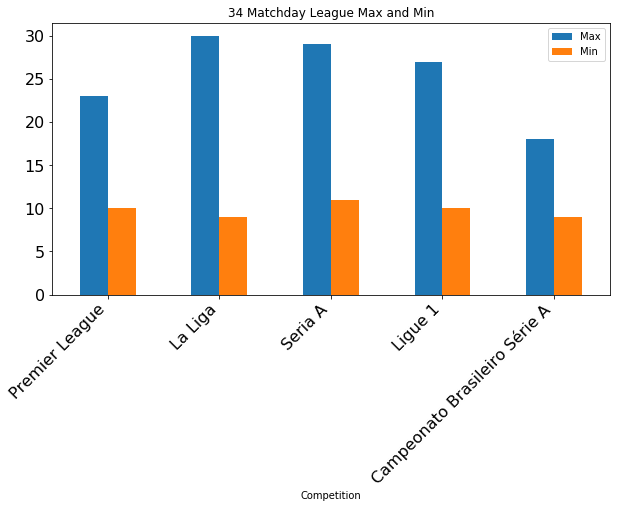

In [334]:
p1 = compute_1["Max"]
p2 = compute_1["Min"]
df = pd.DataFrame({'Max': p1,'Min': p2})
ax = df.plot.bar(figsize=(10,5),fontsize=fontsize,title="34 Matchday League Max and Min")
plt.xticks(rotation=45, ha='right');

We see that the highest scorer in the 38 game league campaigns was in La Liga with 30 goals. The league with the lowest highest scorer was in Campeonato Brasileiro Série A. This is interesting as this is the only Non-European League in our data frame of competitions. This could be due to a lower standard of players in the Campeonato Brasileiro Série A compared to the higher level European leagues.

We see that the minimum amount of goals required to be in the top 20 of these 38 league competitions is very similar(between 9 and 11). This would be expected as the matchday numbers are the same.

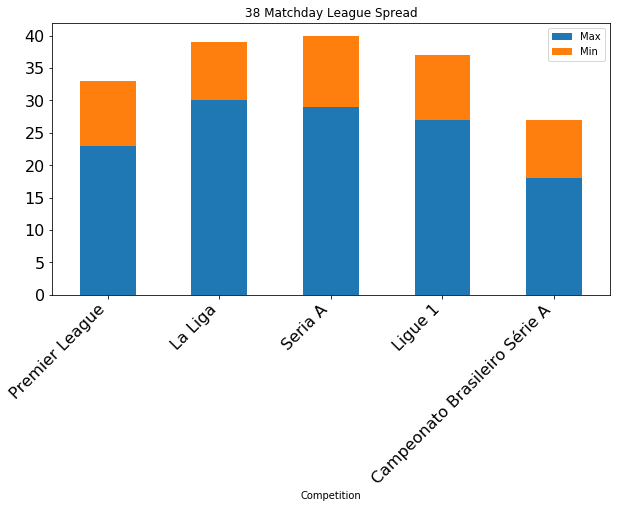

In [335]:
ax = df.plot.bar(figsize=(10,5),fontsize=fontsize,stacked = True,title="38 Matchday League Spread")
plt.xticks(rotation=45, ha='right');

If we stack the data of the max and min values of each competition, it gives a good indication of how the data is spread. We can see that Seria A in particular had a very high min and max value for its Top 20 scorer list. This would suggest a highly comptetitive league.

Now we'll compare look at the 34 game leagues.

In [336]:
compute_2 = topscorer_stats.iloc[5:8]
compute_2

,Matchdays,Max,Min,Mean,Median,Standard Dev.
Competition,,,,,,
Primera Liga,34,24,7,11.45,9.0,5.00
Bundesliga,34,41,8,14.40,11.0,8.77
Eredevisie,34,26,10,14.00,13.5,3.88


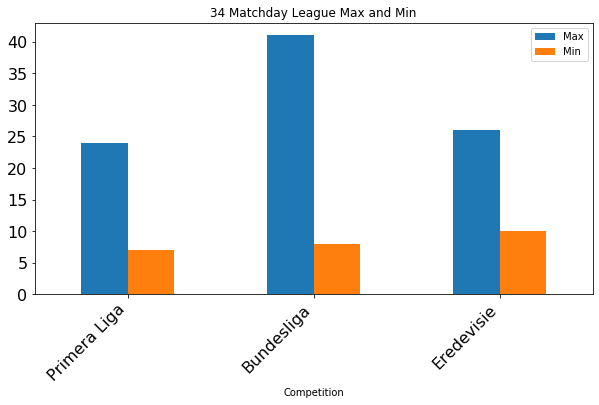

In [337]:
p1 = compute_2["Max"]
p2 = compute_2["Min"]
df1 = pd.DataFrame({'Max': p1,'Min': p2})
ax = df1.plot.bar(figsize=(10,5),fontsize=fontsize,title="34 Matchday League Max and Min")
plt.xticks(rotation=45, ha='right');

We see that the highest scorer in the Bundesliga is substantially greater than the other 34 game competitions. However the minimum of the top 20 lists is similar for these leagues ranging between 7 to 10.

Interestingly, we see that the highest scorers in each of these 34 matchday leagues, is greater than the highest scorer in Campeonato Brasileiro Série A, although there are 4 less matchdays. This further illustrates that there is a higher level of goalscorers in the European Leagues.

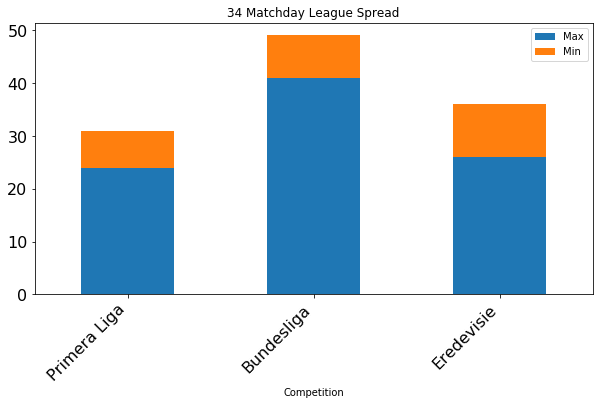

In [338]:
#stacked bar chart
ax = df1.plot.bar(figsize=(10,5),fontsize=fontsize,stacked = True,title="34 Matchday League Spread")
plt.xticks(rotation=45, ha='right');

These 34 game leagues all have very big ranges in their max and min which is illustated on the graph, giving them very large spreads. This could mean that there are really good attackers in this league or poor defending.

Looking at the max on its own.

In [339]:
def compute_max(col_name):
    rows = []
    for competition in competition_names:
        row = {"Competition": competition}
        row["Matchdays"] = dict_matchdays[competition]
        row["Max"] = df_topscorers[competition][col_name].max()
        rows.append(row)
    return pd.DataFrame(rows).set_index("Competition")

In [340]:
maxdf = compute_max("Goals")
maxdf.transpose()

Competition,Premier League,La Liga,Seria A,Ligue 1,Campeonato Brasileiro Série A,Primera Liga,Bundesliga,Eredevisie,English Championship,World Cup
Matchdays,38,38,38,38,38,34,34,34,46,7
Max,23,30,29,27,18,24,41,26,30,6


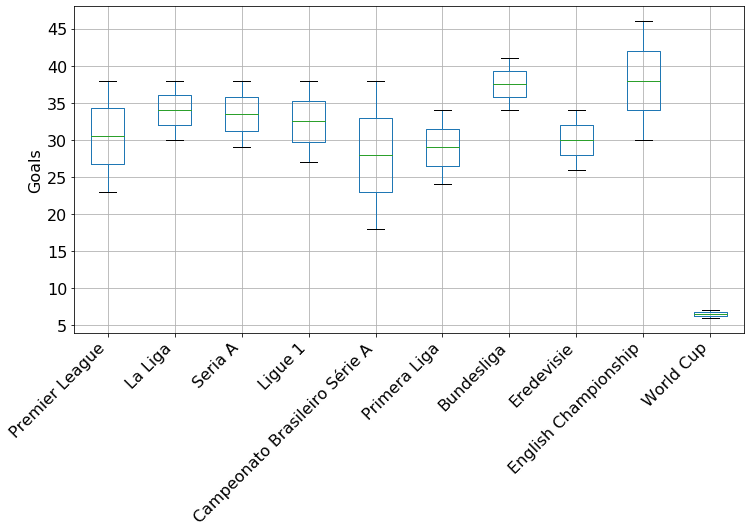

In [341]:
#boxplot display of max scorers in various leagues
ax = maxdf.transpose().boxplot(figsize=(12,6), fontsize=fontsize)
ax.set_ylabel("Goals", fontsize=fontsize);
plt.xticks(rotation=45, ha='right');

# Position Analysis
We will now analysis the different positions of goalscorers that made the top 20 list of scorers in  the various competitions.

In [342]:
position_counts = {}
for competition in competition_names:
    count = df_topscorers[competition]["Position"].value_counts()
    position_counts[competition] = (count)/len(df_topscorers[competition])
df_position_counter = pd.DataFrame(position_counts).fillna(0)
df_position_counter

,Premier League,La Liga,Seria A,Ligue 1,Campeonato Brasileiro Série A,Primera Liga,Bundesliga,Eredevisie,English Championship,World Cup
Attacker,0.8,0.8,0.8,0.8,0.75,0.8,0.7,0.7,0.65,0.65
Defender,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.10
Midfielder,0.2,0.2,0.2,0.2,0.25,0.2,0.3,0.3,0.35,0.25


We can look at what position is most frequent on the Top 20 Scorers list for each competition.

In [343]:
#see the most frequent positions
df_position_counter.idxmax()

Premier League                   Attacker
La Liga                          Attacker
Seria A                          Attacker
Ligue 1                          Attacker
Campeonato Brasileiro Série A    Attacker
Primera Liga                     Attacker
Bundesliga                       Attacker
Eredevisie                       Attacker
English Championship             Attacker
World Cup                        Attacker
dtype: object

We see that for every competition, attacker is the most frequent position on their Topscorer lists. This would be expected as in football attackers tend to score the most.

In [344]:
x = df_position_counter.transpose()
x

,Attacker,Defender,Midfielder
Premier League,0.80,0.0,0.20
La Liga,0.80,0.0,0.20
Seria A,0.80,0.0,0.20
Ligue 1,0.80,0.0,0.20
Campeonato Brasileiro Série A,0.75,0.0,0.25
Primera Liga,0.80,0.0,0.20
Bundesliga,0.70,0.0,0.30
Eredevisie,0.70,0.0,0.30
English Championship,0.65,0.0,0.35
World Cup,0.65,0.1,0.25


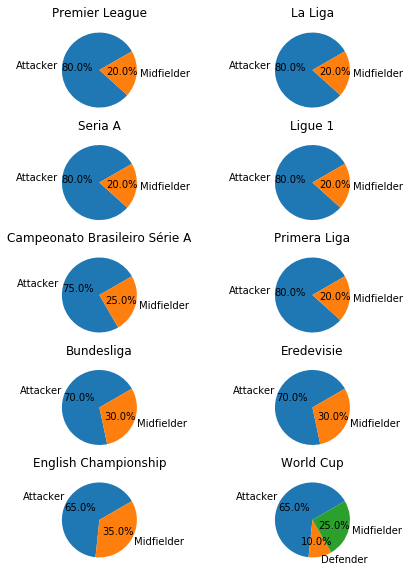

In [345]:
#pie chart displays of positions of scorers on list
fig, axes = plt.subplots(5, 2, figsize=(7, 10))

for i, (idx, row) in enumerate(x.iterrows()):
    ax = axes[i // 2, i % 2]
    row = row[row.gt(row.sum() * .01)]
    ax.pie(row, labels=row.index,autopct = "%2.1f%%",startangle=30)
    ax.set_title(idx)

fig.subplots_adjust(wspace=.2)

The pie charts displays show that in all league competitions, only attackers and midfielders make up the top 20 list. However in the World Cup, there are also defenders on the list. This is most likely due to the fact that there are much less games in the World Cup, giving defenders a better chance of making the list compared to cup competitions who have more games.

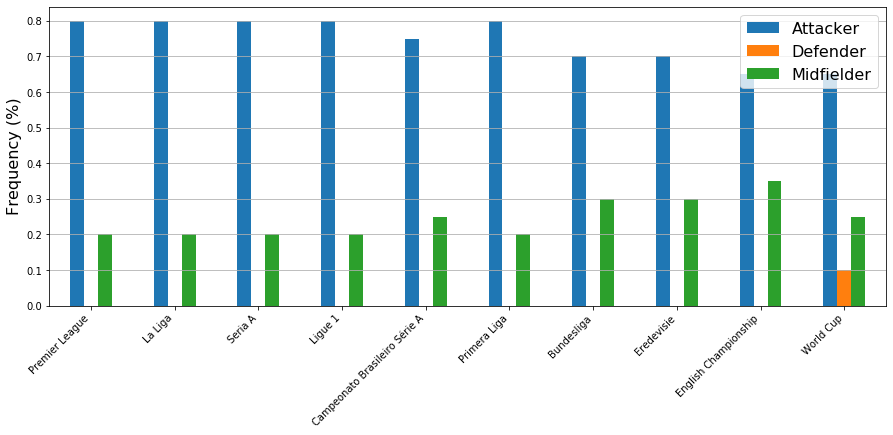

In [346]:
#bar chart display
ax = x.plot.bar(figsize=(15,5.5))
ax.legend(fontsize=fontsize)
ax.set_ylabel("Frequency (%)", fontsize=fontsize)
ax.yaxis.grid(True)
# adjust the x-axis label rotation
plt.xticks(rotation=45, ha='right');

### Similar Leagues

Analyse Leagues that are most Similar to each other using there Stats such as max, min etc...

In [347]:
#measure similiarity using Euclidean distance
d = euclidean_distances(topscorer_stats)
d

array([[ 0.        ,  7.31681298,  7.33534479,  4.33200114,  5.61661994,
         6.82988704, 19.28516638,  5.10176254, 11.08659343, 39.14561707],
       [ 7.31681298,  0.        ,  4.15805934,  3.71114132, 12.56306911,
         8.92582072, 12.3084641 ,  6.09001124,  8.12000015, 42.82082666],
       [ 7.33534479,  4.15805934,  0.        ,  3.4330345 , 12.90134939,
        11.19200624, 14.4346973 ,  6.13896258,  8.69658346, 43.87312014],
       [ 4.33200114,  3.71114132,  3.4330345 ,  0.        ,  9.8575117 ,
         8.31823938, 15.67220909,  4.20469807,  8.87474133, 41.58606713],
       [ 5.61661994, 12.56306911, 12.90134939,  9.8575117 ,  0.        ,
         8.03027296, 24.13707311,  9.51881975, 15.27513506, 36.17487174],
       [ 6.82988704,  8.92582072, 11.19200624,  8.31823938,  8.03027296,
         0.        , 17.80309845,  6.40365685, 14.88610251, 34.64332441],
       [19.28516638, 12.3084641 , 14.4346973 , 15.67220909, 24.13707311,
        17.80309845,  0.        , 16.10487614

In [348]:
print("\033[1m"  + "League Profiles")
print('\033[0m')
for i, competition in enumerate(competition_names):
    dmin, dmax = 0, 0
    pos_min, pos_max = None, None
    for j in range(len(competition_names)):
        # skip the diagonal
        if i == j:
            continue
        if pos_min is None or d[i,j] < dmin:
            dmin = d[i,j]
            pos_min = competition_names[j]
        if pos_max is None or d[i,j] > dmax:
            dmax = d[i,j]
            pos_max = competition_names[j]  
    print("%s:\t Most similar to %s, least similar to %s" % (competition, pos_min, pos_max))

League Profiles

Premier League:	 Most similar to Ligue 1, least similar to World Cup
La Liga:	 Most similar to Ligue 1, least similar to World Cup
Seria A:	 Most similar to Ligue 1, least similar to World Cup
Ligue 1:	 Most similar to Seria A, least similar to World Cup
Campeonato Brasileiro Série A:	 Most similar to Premier League, least similar to World Cup
Primera Liga:	 Most similar to Eredevisie, least similar to World Cup
Bundesliga:	 Most similar to La Liga, least similar to World Cup
Eredevisie:	 Most similar to Ligue 1, least similar to World Cup
English Championship:	 Most similar to La Liga, least similar to World Cup
World Cup:	 Most similar to Primera Liga, least similar to English Championship


# League vs Cup Competition Analysis
We will now analyse how the different league campaigns compared to the World Cup based on their top goalscorer charts.

We will compare the World cup to a 38 game league, a 34 game league and a 46 game league. 

In [349]:
#merge Bundesliga with World Cup
df_bl1 = df_topscorers["Bundesliga"].head()
df_wc = df_topscorers["World Cup"].head()
frames = [df_bl1,df_wc]
result = pd.concat(frames)
result.set_index("Rank")

,Name,Goals,Position,Nationality,Age,Team,Matchdays,Comp Winner
Rank,,,,,,,,
1,Robert Lewandowski,41,Attacker,Poland,1988-08-21,FC Bayern München,34,FC Bayern München
2,André Silva,28,Attacker,Portugal,1995-11-06,Eintracht Frankfurt,34,FC Bayern München
3,Erling Haaland,27,Attacker,Norway,2000-07-21,Borussia Dortmund,34,FC Bayern München
4,Andrej Kramarić,20,Attacker,Croatia,1991-06-19,TSG 1899 Hoffenheim,34,FC Bayern München
5,Wout Weghorst,20,Attacker,Netherlands,1992-08-07,VfL Wolfsburg,34,FC Bayern München
1,Harry Kane,6,Attacker,England,1993-07-28,England,7,France
2,Denis Cheryshev,4,Attacker,Russia,1990-12-26,Russia,7,France
3,Cristiano Ronaldo,4,Attacker,Portugal,1985-02-05,Portugal,7,France
4,Antoine Griezmann,4,Attacker,France,1991-03-21,France,7,France


In [350]:
#compare stats
compare = topscorer_stats.transpose()
df = pd.DataFrame(compare, columns= ["Bundesliga", "World Cup"])
df

,Bundesliga,World Cup
Matchdays,34.00,7.00
Max,41.00,6.00
Min,8.00,2.00
Mean,14.40,3.05
Median,11.00,3.00
Standard Dev.,8.77,1.05


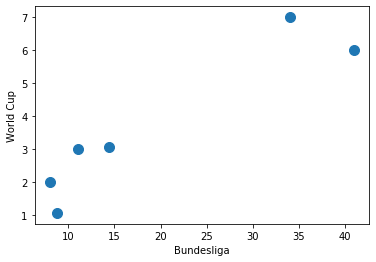

In [351]:
#scatter plot to see how their stats compare
df.plot.scatter(x = "Bundesliga", y = "World Cup", s =100)

We see there is a huge difference in the standard deviation and means of these 2 competitions and there's a greater spread of data in the Bundesliga. This would be expected considering the difference in matchday numbers. The high standard deviation in the Bundesliga would imply that there is a vast difference in the level of performance of the goal scorers on the Top 20 list.

Now we'll look a 38 matchday competition.

In [352]:
#merge Premier League and World Cup Top 5 scorers
df_pl = df_topscorers["Premier League"].head()
frames = [df_pl,df_wc]
result = pd.concat(frames)
result.set_index("Rank")

,Name,Goals,Position,Nationality,Age,Team,Matchdays,Comp Winner
Rank,,,,,,,,
1,Harry Kane,23,Attacker,England,1993-07-28,Tottenham Hotspur FC,38,Manchester City FC
2,Mohamed Salah,22,Attacker,Egypt,1992-06-15,Liverpool FC,38,Manchester City FC
3,Bruno Fernandes,18,Midfielder,Portugal,1994-09-08,Manchester United FC,38,Manchester City FC
4,Patrick Bamford,17,Attacker,England,1993-09-05,Leeds United FC,38,Manchester City FC
5,Son Heungmin,17,Midfielder,Korea Republic,1992-07-08,Tottenham Hotspur FC,38,Manchester City FC
1,Harry Kane,6,Attacker,England,1993-07-28,England,7,France
2,Denis Cheryshev,4,Attacker,Russia,1990-12-26,Russia,7,France
3,Cristiano Ronaldo,4,Attacker,Portugal,1985-02-05,Portugal,7,France
4,Antoine Griezmann,4,Attacker,France,1991-03-21,France,7,France


In [353]:
#compare stats
compare = topscorer_stats.transpose()
df = pd.DataFrame(compare, columns= ["Premier League", "World Cup"])
df

,Premier League,World Cup
Matchdays,38.00,7.00
Max,23.00,6.00
Min,10.00,2.00
Mean,14.05,3.05
Median,12.50,3.00
Standard Dev.,3.72,1.05


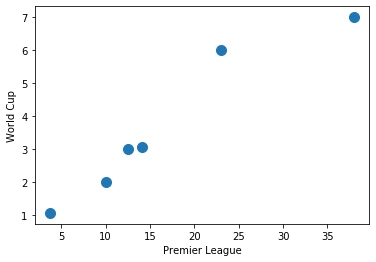

In [354]:
#scatter plot to see how their stats compare
df.plot.scatter(x = "Premier League", y = "World Cup", s =100)

We see there is a less difference in the standard deviation of these 2 competitions compared to the Bundesliga, but there's a greater spread of data in the Premier League. This would be expected considering the difference in matchday numbers. The smaller gap in standard deviations in would imply that the difference in the level of performance of the goal scorers on the Top 20 list is a lot closer in comparison to a 7 matchday competetition like the World Cup.

Finally, we'll look at a 46 matchday competition.

In [355]:
#merge ELC with world Cup 
df_elc = df_topscorers["English Championship"].head()
frames = [df_elc,df_wc]
result = pd.concat(frames)
result.set_index("Rank")

,Name,Goals,Position,Nationality,Age,Team,Matchdays,Comp Winner
Rank,,,,,,,,
1,Ivan Toney,30,Attacker,England,1996-03-16,Brentford FC,46,Norwich City FC
2,Adam Armstrong,28,Attacker,England,1997-02-10,Blackburn Rovers FC,46,Norwich City FC
3,Teemu Pukki,26,Attacker,Finland,1990-03-29,Norwich City FC,46,Norwich City FC
4,Kieffer Moore,20,Midfielder,Wales,1992-08-08,Cardiff City FC,46,Norwich City FC
5,Lucas João,19,Attacker,Portugal,1993-09-04,Reading FC,46,Norwich City FC
1,Harry Kane,6,Attacker,England,1993-07-28,England,7,France
2,Denis Cheryshev,4,Attacker,Russia,1990-12-26,Russia,7,France
3,Cristiano Ronaldo,4,Attacker,Portugal,1985-02-05,Portugal,7,France
4,Antoine Griezmann,4,Attacker,France,1991-03-21,France,7,France


In [356]:
#compare competitions goal stats
compare = topscorer_stats.transpose()
df = pd.DataFrame(compare, columns= ["English Championship", "World Cup"])
df

,English Championship,World Cup
Matchdays,46.00,7.00
Max,30.00,6.00
Min,9.00,2.00
Mean,15.45,3.05
Median,13.50,3.00
Standard Dev.,6.16,1.05


In [357]:
#scatter plot to see how their stats compare
df.plot.scatter(x = "Premier League", y = "World Cup", s =100)

KeyError: 'Premier League'

We see there is even less difference in the standard deviation of these 2 competitions compared to the Bundesliga and Premier League, but there's a greater spread of data in the English Championship. This would be expected considering the difference in matchday numbers. The smaller gap in standard deviations in would imply that the difference in the level of performance of the goal scorers on the Top 20 list is a lot closer in comparison to a 7 matchday competetition like the World Cup. It could also imply a higher level of competitiveness in this 46 matchday league compared to the 34 and 38 matchday ones. 

We could also look at Campeonato Brasileiro Série A as a comparitor as this is the only non European league.

In [358]:
#merge Campeonato Brasileiro Série A Top 5 with World Cup top 5
df_bsa = df_topscorers["Campeonato Brasileiro Série A"].head()
frames = [df_bsa,df_wc]
result = pd.concat(frames)
result.set_index("Rank")

,Name,Goals,Position,Nationality,Age,Team,Matchdays,Comp Winner
Rank,,,,,,,,
1,Claudinho,18,Attacker,Brazil,1997-01-28,RB Bragantino,38,CR Flamengo
2,Luciano,18,Attacker,Brazil,1993-05-18,São Paulo FC,38,CR Flamengo
3,Marinho,17,Attacker,Brazil,1990-05-29,Santos FC,38,CR Flamengo
4,Thiago Galhardo,17,Midfielder,Brazil,1989-07-20,SC Internacional,38,CR Flamengo
5,Germán Cano,14,Attacker,Argentina,1988-02-02,CR Vasco da Gama,38,CR Flamengo
1,Harry Kane,6,Attacker,England,1993-07-28,England,7,France
2,Denis Cheryshev,4,Attacker,Russia,1990-12-26,Russia,7,France
3,Cristiano Ronaldo,4,Attacker,Portugal,1985-02-05,Portugal,7,France
4,Antoine Griezmann,4,Attacker,France,1991-03-21,France,7,France


In [359]:
#compare the goal stats
compare = topscorer_stats.transpose()
df = pd.DataFrame(compare, columns= ["Campeonato Brasileiro Série A", "World Cup"])
df

,Campeonato Brasileiro Série A,World Cup
Matchdays,38.00,7.00
Max,18.00,6.00
Min,9.00,2.00
Mean,12.35,3.05
Median,11.00,3.00
Standard Dev.,3.08,1.05


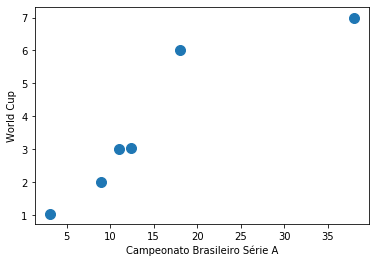

In [360]:
#scatter plot to see how their stats compare
df.plot.scatter(x = "Campeonato Brasileiro Série A", y = "World Cup", s =100)

We see there is even less difference in the standard deviation of these 2 competitions compared to the Bundesliga,Premier League and English Championship, but there's a greater spread of data in the Campeonato Brasileiro Série A. This would be expected considering the difference in matchday numbers. The smaller gap in standard deviations in would imply that the difference in the level of performance of the goal scorers on the Top 20 list is a lot closer in comparison to a 7 matchday competetition like the World Cup. It is surprising how much closer the gap is for Campeonato Brasileiro Série A as it is a 38 matchday competition. This would imply a low level of goalscoring in this competitiion or a very competitive league with high levels of defending.

### TopScorer Position to Comp Winner Comparison for 38 Matchday Competitions

In [361]:
#merge Premier League Top 5 with World Cup top 5
df_pl = df_topscorers["Premier League"].head()
frames = [df_pl,df_wc]
result = pd.concat(frames)
result.set_index("Rank")

,Name,Goals,Position,Nationality,Age,Team,Matchdays,Comp Winner
Rank,,,,,,,,
1,Harry Kane,23,Attacker,England,1993-07-28,Tottenham Hotspur FC,38,Manchester City FC
2,Mohamed Salah,22,Attacker,Egypt,1992-06-15,Liverpool FC,38,Manchester City FC
3,Bruno Fernandes,18,Midfielder,Portugal,1994-09-08,Manchester United FC,38,Manchester City FC
4,Patrick Bamford,17,Attacker,England,1993-09-05,Leeds United FC,38,Manchester City FC
5,Son Heungmin,17,Midfielder,Korea Republic,1992-07-08,Tottenham Hotspur FC,38,Manchester City FC
1,Harry Kane,6,Attacker,England,1993-07-28,England,7,France
2,Denis Cheryshev,4,Attacker,Russia,1990-12-26,Russia,7,France
3,Cristiano Ronaldo,4,Attacker,Portugal,1985-02-05,Portugal,7,France
4,Antoine Griezmann,4,Attacker,France,1991-03-21,France,7,France


If we compare the Top 5 scorers in the Premier League to that of the World Cup,we will see that the Top Scorer of the World Cup is the same as the Premier League. 

In [362]:
#get rows with Harry Kane to see how he performed 
result.loc[result["Name"] == "Harry Kane"].set_index("Rank")

,Name,Goals,Position,Nationality,Age,Team,Matchdays,Comp Winner
Rank,,,,,,,,
1,Harry Kane,23,Attacker,England,1993-07-28,Tottenham Hotspur FC,38,Manchester City FC
1,Harry Kane,6,Attacker,England,1993-07-28,England,7,France


Harry Kane is the Top Scorer in both competitons(a 38 matchday league and the World Cup 2018)with a total of 29 goals. However we see that he was not on the Competition winning team in either competition. So this would suggest that being the competition Top Scorer does not correlate to a team winning that Competition.

Let us look at the World Cup top 5 goalscorers list again.

In [363]:
df_topscorers["World Cup"].head()

,Rank,Name,Goals,Position,Nationality,Age,Team,Matchdays,Comp Winner
Competition,,,,,,,,,
World Cup,1,Harry Kane,6,Attacker,England,1993-07-28,England,7,France
World Cup,2,Denis Cheryshev,4,Attacker,Russia,1990-12-26,Russia,7,France
World Cup,3,Cristiano Ronaldo,4,Attacker,Portugal,1985-02-05,Portugal,7,France
World Cup,4,Antoine Griezmann,4,Attacker,France,1991-03-21,France,7,France
World Cup,5,Romelu Lukaku,4,Attacker,Belgium,1993-05-13,Belgium,7,France


We see that the only player in the Top 5 to be on the winning team is Antoine Griezmann. So let's see how he performed in his league to see if was on the winning team in both comptetitions he was in.

In [364]:
#merge data frames to compare Griezmann's performance
df_pd = df_topscorers["La Liga"]
frames = [df_pd,df_wc]
result = pd.concat(frames)
result.set_index("Rank")

,Name,Goals,Position,Nationality,Age,Team,Matchdays,Comp Winner
Rank,,,,,,,,
1,Lionel Messi,30,Attacker,Argentina,1987-06-24,FC Barcelona,38,Club Atlético de Madrid
2,Gerard Moreno,23,Attacker,Spain,1992-04-07,Villarreal CF,38,Club Atlético de Madrid
3,Karim Benzema,23,Attacker,France,1987-12-19,Real Madrid CF,38,Club Atlético de Madrid
4,Luis Suárez,21,Attacker,Uruguay,1987-01-24,Club Atlético de Madrid,38,Club Atlético de Madrid
5,Youssef En-Nesyri,18,Attacker,Morocco,1997-06-01,Sevilla FC,38,Club Atlético de Madrid
6,Alexander Isak,16,Midfielder,Sweden,1999-09-21,Real Sociedad de Fútbol,38,Club Atlético de Madrid
7,Iago Aspas,14,Attacker,Spain,1987-08-01,RC Celta de Vigo,38,Club Atlético de Madrid
8,José Luis Morales,13,Attacker,Spain,1987-07-23,Levante UD,38,Club Atlético de Madrid
9,Rafael Mir,13,Attacker,Spain,1997-06-18,SD Huesca,38,Club Atlético de Madrid


In [365]:
#get rows in data frame with Antoine Griezmann in it
result.loc[result["Name"] == "Antoine Griezmann"].set_index("Rank")

,Name,Goals,Position,Nationality,Age,Team,Matchdays,Comp Winner
Rank,,,,,,,,
10,Antoine Griezmann,13,Attacker,France,1991-03-21,FC Barcelona,38,Club Atlético de Madrid
4,Antoine Griezmann,4,Attacker,France,1991-03-21,France,7,France


We now see that Antoine Griezmann did not even rank in the Top 5 in La Liga and he was not on the winning team either. So although he won the World Cup this does not correlate to success in league performance.

# Conclusions

In this assignment, we analysed the Top 20 goalscorers in 10 competitions(9 different leagues and the World Cup 2018). As expected, the league competitions were least similar to the World Cup as there are signficantly less matchdays in this competition compared to the 9 others. We also saw that the one Non-European league(Campeonato Brasileiro Série A), had significantly lower stats than the other European Leagues, which would suggest a higher level of football in Europe than in South America(i.e. Brazil).

The dataset was collected for the Football Data API using the specifications from the API which were required for Data Collection. This raw data was then cleaned and processed in order to produce a dataset that would be useful for the above analysis.

Further Analysis that could be done on this dataset:
. Analyse how players' ages correlate to how high they are on the Top 20 scorers list.
. If we had older data over many seasons, we could analyse how consistently players made the Top 20 scorers list as well as how they performed at other World Cups. 